# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [130]:
from mpl_toolkits import mplot3d
import sys
sys.path.append('..\\')
# print(sys.path)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

%load_ext autoreload
%autoreload 2

from Pathfinders import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Unload the data from a particular scan
This should only include data from a Fullscan module

In [131]:
path = os.path.abspath('..\\')
test_no = 9
current_file = r"\Debugging Scripts\test_%s.json" % test_no
# current_file = r"\test_%s.json" % test_no

debug_mode = False

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [132]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = json_data["max_point"]

r = dict()
active_rom = []
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2
    if r[DoF] != 0.0:
        active_rom.append(DoF)

indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
mags = np.array([p[1] for p in point_mags])

linInter = LinearNDInterpolator(points, mags)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

p_dict = dict()
for p in point_mags:
    p_dict[(tuple(p[0][0]),tuple(p[0][1]))] = p[1]

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)

In [133]:
# scanner = DivisionSearch(4, r['Z'], r['Rx'], r['Ry'])
scanner = DivisionDiscreteDegree(6, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)

p = scanner.next()
i = 0
 
while p != 1 and i < 10000:
    i += 1

    request = np.array([p[indices[a][0]][indices[a][1]] for a in active_rom])
    mag = linInter(request)
    if math.isnan(mag):
        if debug_mode:
            print(request)
        mag = [0]

    scanner.newMag((p, mag[0]), True)
    # print(p)
    p = scanner.next()

file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\test_%s_%s_draft.json" % (test_no, file_itr)):
    file_itr += 1

output_file = "\\Debugging Scripts\\test_%s_%s_draft.json" % (test_no, file_itr)
scanner.save_points(path + output_file)

if debug_mode:
    print(f"Number of points to solve: {i}")
    print(path + output_file)

(((0, 0, -8.5), (40.0, -24.0, 0)), 276.65999999999997)
Bounds: {'X': [0, 0], 'Y': [0, 0], 'Z': [-12.5, 7.5], 'Rx': [-40.0, 40.0], 'Ry': [-40.0, 40.0], 'Rz': [0, 0]}
Temp: {'X': 0, 'Y': 0, 'Z': -8.5, 'Rx': 40.0, 'Ry': -24.0, 'Rz': 0}
Inc_size: {'X': 0, 'Y': 0, 'Z': 3.3333333333333335, 'Rx': 13.333333333333334, 'Ry': 13.333333333333334, 'Rz': 0}
X
[0, 0]
Y
[0, 0]
Z
[-12.5, 7.5]
Rx
[-40.0, 40.0]
Ry
[-40.0, 40.0]
Rz
[0, 0]
center of the second stage rom: ((0.0, 0.0, -8.5), (26.666666666666664, -24.0, 0.0))
Bounds of the second stage: {'X': [0, 0], 'Y': [0, 0], 'Z': [-11.833333333333334, -5.166666666666666], 'Rx': [13.333333333333332, 40.0], 'Ry': [-37.333333333333336, -10.666666666666666], 'Rz': [0, 0]}
{'X': 0, 'Y': 0, 'Z': 3.3333333333333335, 'Rx': 13.333333333333334, 'Ry': 13.333333333333334, 'Rz': 0}


In [134]:
with open(path + output_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
# divisions = json_data["divisions"]
point_mags_2 = json_data["points"]
search_max = json_data["max_point"]

print(len(point_mags_2))

480


In [135]:
Zs = []
Rxs = []
Rys = []
mags = []

for p in point_mags:
    Zs.append(p[0][0][2])
    Rxs.append(p[0][1][0])
    Rys.append(p[0][1][1])
    mags.append(p[1])

Zs1 = []
Rxs1 = []
Rys1 = []

for p in point_mags_2:
    Zs1.append(p[0][0][2])
    Rxs1.append(p[0][1][0])
    Rys1.append(p[0][1][1])

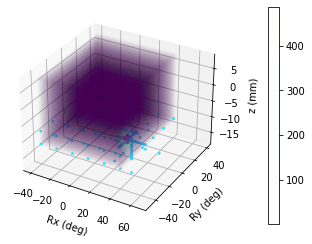

In [136]:
ax = plt.axes(projection='3d')
fig = ax.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.01, linewidth=0.05)
plt.colorbar(fig, pad=0.13,cmap='viridis', alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 300

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)


In [137]:
a = point_mags_2[0][0]
distance = 0

for i in range(1, len(point_mags_2)):
    b = point_mags_2[i][0]
    t = 0
    for j in range(3):
        t += (a[0][j] - b[0][j])**2
        t += (a[1][j] - b[1][j])**2

    distance += t**0.5
    a = b

for j in range(3):
    t += (scan_max[0][0][j] - search_max[0][0][j])**2
    t += (scan_max[0][1][j] - search_max[0][1][j])**2


print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value: {scan_max}")
print(f"\tSearch max value: {search_max}")
print(f"\tDistance from target to found value: {t**0.5}")

Pathfinder evalutation: 
	Total search-space distance traveled: 2188.877757951192
	Scan max value: [[[0.0, 0.0, -7.0], [34.0, -26.0, 0.0]], 487.5]
	Search max value: [[[0, 0, -7.001602564102564], [36.0, -24.0, 0]], 487.47833333333335]
	Distance from target to found value: 2.830780135877592
